In [27]:
import ambulance_game as abg
import numpy as np
import math
import matplotlib.pyplot as plt
import functools
import sympy as sym

# Blocking time formula (algebraic approach)

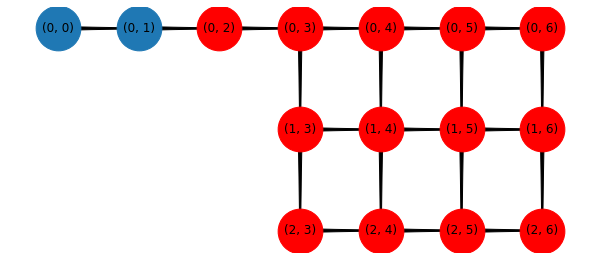

In [3]:
abg.markov.visualise_ambulance_markov_chain(2, 3, 6, 2)

## Blocking States
$$ S_b = \{ (u,v) \in S \; | \; u > 0 \} $$

In [4]:
def is_blocking_state(state):
    """
    Checks if blocking occurs in the given state
    """
    return state[0] > 0

## Accepting States
$$
S_A^A = 
\begin{cases}
\{(u,v) \in S \; | \; u < M \}  & \text{if } T \leq N\\
\{(u,v) \in S \; | \; v < N \}  & \text{otherwise}
\end{cases}
$$

In [34]:
def is_accepting_state(state, patient_type, threshold, system_capacity, parking_capacity):
    """Checks if ambulance patients are accepted at this state or are lost to the system
    """ 
    if patient_type == "ambulance":
        condition = (
            (state[0] < parking_capacity)
            if (threshold <= system_capacity)
            else (state[1] < system_capacity)
        )
    if patient_type == "others":
        condition = state[1] < system_capacity

    return condition

## Expected sojourn time in a state
$$ 
c(u,v) = 
\begin{cases}
    \frac{1}{\min(v,C) \mu}, & \text{if } v = C\\
    \frac{1}{\min(v,C) \mu + \lambda^o}, & \text{otherwise}
\end{cases}
$$

In [35]:
def expected_sojourn_time_in_markov_state(state, lambda_o, mu, num_of_servers, system_capacity):
    """The expected time of the markov chain model at the state given. 
    Note here that for a state (u,v) where v = system capacity (C) no other arrivals can occur and thus the
    rate at which the model leaves thatstate changes.
    """ 
    if state[1] == system_capacity:
        return 1 / (min(state[1], num_of_servers) * mu)
    return 1 / (min(state[1], num_of_servers) * mu + lambda_o)

## Probability of service and other patient arrival

$$
p_s(u,v) = \frac{\min(v,C)\mu}{\lambda^o + \min(v,C)\mu}, \qquad
p_o(u,v) = \frac{\lambda^o}{\lambda^o + \min(v,C)\mu}
$$

In [36]:
def prob_service(state, lambda_o, mu, num_of_servers):
    return (min(state[1], num_of_servers) * mu) / (lambda_o + (mu * min(state[1], num_of_servers)))

def prob_other_arrival(state, lambda_o, mu, num_of_servers):
    return lambda_o / (lambda_o + (mu * min(state[1], num_of_servers)))

## Solve system of equations w.r.t $b(u,v) \quad \forall \; (u,v) \in S_b$
$$
b(u,v) = 
\begin{cases} 
    0, & \textbf{if } (u,v) \notin S_b \\
    c(u,v) + b(u - 1, v), & \textbf{if } v = N = T\\
    c(u,v) + b(u, v-1), & \textbf{if } v = N \neq T \\
    c(u,v) + p_s(u,v) b(u-1, v) + p_o(u,v) b(u, v+1), & \textbf{if } u > 0 \textbf{ and } v = T \\
    c(u,v) + p_s(u,v) b(u, v-1) + p_o(u,v) b(u, v+1), & \textbf{otherwise} \\
\end{cases}
$$

## Consider example where $C=2, T=3, N=6, M=2$:

In [37]:
lambda_a = 1
lambda_o = 1
mu = 2
num_of_servers = 2
threshold = 3
system_capacity = 6
parking_capacity = 2

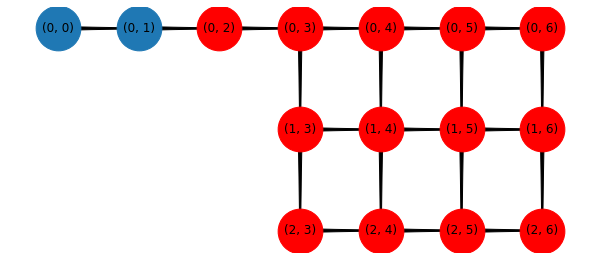

In [9]:
abg.markov.visualise_ambulance_markov_chain(num_of_servers=num_of_servers, threshold=threshold, system_capacity=system_capacity, parking_capacity=parking_capacity)

$$
b(1,3) = c(1,3) + p_s b(0,3) + p_o b(1,4) \\
b(1,4) = c(1,4) + p_s b(1,3) + p_o b(1,5) \\
b(1,5) = c(1,5) + p_s b(1,4) + p_o b(1,6) \\
b(1,6) = c(1,6) + b(1,5)
$$

$$
b(2,3) = c(2,3) + p_s b(1,3) + p_o b(2,4) \\
b(2,4) = c(2,4) + p_s b(2,3) + p_o b(1,5) \\
b(2,5) = c(2,5) + p_s b(2,4) + p_o b(1,6) \\
b(2,6) = c(2,6) + b(2,5)
$$


In [38]:
def get_symbolic_blocking_time_equation(
    state, lambda_o, mu, num_of_servers, threshold, system_capacity, parking_capacity
):
    if not is_blocking_state(state):
        return 0

    if state[0] >= 1 and state[1] == threshold:
        service_state = (state[0] - 1, state[1])
    else:
        service_state = (state[0], state[1] - 1)
    others_arrival_state = (state[0], state[1] + 1)

    sym_state = sym.S("b" + str(state))
    sym_service_state = sym.S("b" + str(service_state))
    sym_others_arrival_state = sym.S("b" + str(others_arrival_state))

    time_blocked = expected_sojourn_time_in_markov_state(state, lambda_o, mu, num_of_servers, system_capacity) 
    if state[1] < system_capacity: 
        time_blocked += prob_service(state, lambda_o, mu, num_of_servers) * (sym_service_state) 
        time_blocked += prob_other_arrival(state, lambda_o, mu, num_of_servers) * (sym_others_arrival_state)
    else:
        time_blocked += (sym_service_state) 
    time_blocked -= sym_state
    
    return time_blocked

In [39]:
for state in abg.markov.build_states(threshold=threshold, system_capacity=system_capacity, parking_capacity=parking_capacity):
    if is_blocking_state(state):
        print(get_symbolic_blocking_time_equation(state, lambda_o, mu, num_of_servers, threshold, system_capacity, parking_capacity))

0.8*b(0, 3) - b(1, 3) + 0.2*b(1, 4) + 0.2
0.8*b(1, 3) - b(2, 3) + 0.2*b(2, 4) + 0.2
0.8*b(1, 3) - b(1, 4) + 0.2*b(1, 5) + 0.2
0.8*b(2, 3) - b(2, 4) + 0.2*b(2, 5) + 0.2
0.8*b(1, 4) - b(1, 5) + 0.2*b(1, 6) + 0.2
0.8*b(2, 4) - b(2, 5) + 0.2*b(2, 6) + 0.2
b(1, 5) - b(1, 6) + 0.25
b(2, 5) - b(2, 6) + 0.25


## Solving for all $b(u,v)$ using numpy.linalg.solve()

$$
- b(1,3) + p_o b(1,4) = - c(1,3) \\
- b(1,4) + p_s b(1,3) + p_o b(1,5) = - c(1,4) \\
- b(1,5) + p_s b(1,4) + p_o b(1,6) = - c(1,5) \\
- b(1,6) + b(1,5) = - c(1,6) \\
$$

$$
- b(2,3) + p_s b(1,3) + p_o b(2,4) = - c(2,3) \\
- b(2,4) + p_s b(2,3) + p_o b(1,5) = - c(2,4) \\
- b(2,5) + p_s b(2,4) + p_o b(1,6) = - c(2,5) \\
- b(2,6) + b(2,5) = - c(2,6) \\
$$

$$
\begin{pmatrix}
    -1 & p_o & 0 & 0 & 0 & 0 & 0 & 0 \\ %(1,3)
    p_s & -1 & p_o & 0 & 0 & 0 & 0 & 0 \\ %(1,4)
    0 & p_s & -1 & p_o & 0 & 0 & 0 & 0 \\ %(1,5)
    0 & 0 & 1 & -1 & 0 & 0 & 0 & 0 \\ %(1,6)
    p_s & 0 & 0 & 0 & -1 & p_o & 0 & 0 \\ %(2,3)
    0 & 0 & 0 & 0 & p_s & -1 & p_o & 0 \\ %(2,4)
    0 & 0 & 0 & 0 & 0 & p_s & -1 & p_o \\ %(2,5)
    0 & 0 & 0 & 0 & 0 & 0 & 1 & -1 \\ %(2,6)
\end{pmatrix}
\begin{pmatrix}
    b(1,3) \\
    b(1,4) \\
    b(1,5) \\
    b(1,6) \\
    b(2,3) \\
    b(2,4) \\
    b(2,5) \\
    b(2,6) \\
\end{pmatrix}
= 
\begin{pmatrix}
    -c(1,3) \\
    -c(1,4) \\
    -c(1,5) \\
    -c(1,6) \\
    -c(2,3) \\
    -c(2,4) \\
    -c(2,5) \\
    -c(2,6) \\
\end{pmatrix}
$$

In [40]:
def get_coefficients_row_of_array_associated_with_state(
    state, lambda_o, mu, num_of_servers, threshold, system_capacity, parking_capacity
):
    if not is_blocking_state(state):
        return 0

    if state[0] >= 1 and state[1] == threshold:
        service_state = (state[0] - 1, state[1])
    else:
        service_state = (state[0], state[1] - 1)
    others_arrival_state = (state[0], state[1] + 1)

    lhs_coefficient_row = np.zeros([parking_capacity,system_capacity - threshold + 1])
    lhs_coefficient_row[state[0] - 1, state[1] - threshold] = -1

    if service_state[0] > 0:
        if state[1] < system_capacity:
            entry = prob_service(state, lambda_o, mu, num_of_servers)
        else: 
            entry = 1
        lhs_coefficient_row[service_state[0] - 1, service_state[1] - threshold] = entry
    if others_arrival_state[1] <= system_capacity:
        lhs_coefficient_row[others_arrival_state[0] - 1, others_arrival_state[1] - threshold] = prob_other_arrival(state, lambda_o, mu, num_of_servers)
    lhs_coefficient_row = np.reshape(lhs_coefficient_row, (1, len(lhs_coefficient_row) * len(lhs_coefficient_row[0])))[0]
    
    rhs_value = - expected_sojourn_time_in_markov_state(state, lambda_o, mu, num_of_servers, system_capacity) 

    return lhs_coefficient_row, rhs_value

In [41]:
def get_blocking_times_array_of_coefficients(lambda_o, mu, num_of_servers, threshold, system_capacity, parking_capacity):
    all_coefficients_array = np.array([])
    for state in abg.markov.build_states(threshold=threshold, system_capacity=system_capacity, parking_capacity=parking_capacity):
        if is_blocking_state(state):
            system_coefficients = get_coefficients_row_of_array_associated_with_state(state, lambda_o, mu, num_of_servers, threshold, system_capacity, parking_capacity)
            if len(all_coefficients_array) == 0:
                all_coefficients_array = system_coefficients[0]
                constant_column = [system_coefficients[1]]
            else:
                all_coefficients_array = np.vstack([all_coefficients_array, system_coefficients[0]])
                constant_column.append(system_coefficients[1])
    
    return all_coefficients_array, constant_column

In [42]:
def convert_solution_to_correct_array_format(array, threshold, system_capacity, parking_capacity):

    new_array = np.reshape(array, (parking_capacity, system_capacity - threshold + 1))
    top_row = [0 for _ in range(system_capacity - threshold + 1)]
    new_array = np.vstack([top_row, new_array])

    right_columns = [[0 for _ in range(threshold)] for _ in range(parking_capacity + 1)]
    new_array = np.hstack([right_columns, new_array])

    return new_array

In [43]:
def get_blocking_times_of_all_states(lambda_o, mu, num_of_servers, threshold, system_capacity, parking_capacity):
    
    M, b = get_blocking_times_array_of_coefficients(lambda_o, mu, num_of_servers, threshold, system_capacity, parking_capacity)
    state_blocking_times = np.linalg.solve(M, b)
    state_blocking_times = convert_solution_to_correct_array_format(state_blocking_times, threshold, system_capacity, parking_capacity)

    return state_blocking_times

## Mean blocking time
$$ B = \frac{\sum_{(u,v) \in S_A} \pi_{(u,v)} \; b(u,v)}{\sum_{(u,v) \in S_A} \pi_{(u,v)}} $$

In [44]:
def mean_blocking_time_formula(all_states, pi, lambda_o, mu, num_of_servers, threshold, system_capacity, parking_capacity):
    mean_blocking_time = 0
    prob_accept_ambulance = 0
    blocking_times = get_blocking_times_of_all_states(lambda_o, mu, num_of_servers, threshold, system_capacity, parking_capacity)
    for u, v in all_states:
        if is_accepting_state((u, v), "ambulance", threshold, system_capacity, parking_capacity):
            arriving_state = (u + 1, v) if v >= threshold else (u, v + 1)
            mean_blocking_time += blocking_times[arriving_state] * pi[u, v]
            prob_accept_ambulance += pi[u, v]
    return mean_blocking_time / prob_accept_ambulance

## Comparing Simulation and Markov chain results

**1. Simulation blocking time**

In [45]:
times = abg.simulation.get_multiple_runs_results(
            lambda_a=lambda_a,
            lambda_o=lambda_o,
            mu=mu,
            num_of_servers=num_of_servers,
            threshold=threshold,
            system_capacity=system_capacity,
            parking_capacity=parking_capacity,
            num_of_trials=10,
            seed_num=0,
            runtime=1000,
            patient_type="ambulance",
            warm_up_time=100
        )
simulation_blocking_times = [np.mean(b.blocking_times) for b in times]
np.mean(simulation_blocking_times)

0.07566107719653102

**2. Markov chain blocking time**

In [46]:
def get_mean_blocking_time_markov(
    lambda_a,
    lambda_o,
    mu,
    num_of_servers,
    threshold,
    system_capacity,
    parking_capacity,
    algebraic_function=np.linalg.solve,
):
    transition_matrix = abg.markov.get_transition_matrix(
        lambda_a,
        lambda_o,
        mu,
        num_of_servers,
        threshold,
        system_capacity,
        parking_capacity,
    )
    pi = abg.markov.get_steady_state_algebraically(
        transition_matrix, algebraic_function=algebraic_function
    )
    all_states = abg.markov.build_states(threshold=threshold, system_capacity=system_capacity, parking_capacity=parking_capacity)
    state_probabilities = abg.markov.get_markov_state_probabilities(
        pi, all_states, output=np.ndarray
    )
    mean_blocking_time = mean_blocking_time_formula(all_states, state_probabilities, lambda_o, mu, num_of_servers, threshold, system_capacity, parking_capacity)

    return mean_blocking_time

In [47]:
get_mean_blocking_time_markov(lambda_a, lambda_o, mu, num_of_servers, threshold, system_capacity, parking_capacity)

0.07330951918092277

**3. Simulation blocking time (using state probabilities)**

In [48]:
def get_mean_blocking_time_simulation(
    lambda_a,
    lambda_o,
    mu,
    num_of_servers,
    threshold,
    system_capacity,
    parking_capacity,
    seed_num=None,
    num_of_trials=10,
    runtime=2000
):
    state_probabilities = abg.simulation.get_average_simulated_state_probabilities(
        lambda_a,
        lambda_o,
        mu,
        num_of_servers,
        threshold,
        system_capacity,
        parking_capacity,
        seed_num=seed_num,
        num_of_trials=num_of_trials,
        runtime=runtime
    )

    all_states = [
        (u, v)
        for v in range(state_probabilities.shape[1])
        for u in range(state_probabilities.shape[0])
        if state_probabilities[u, v] > 0
    ]

    mean_blocking_time = mean_blocking_time_formula(all_states, state_probabilities, lambda_o, mu, num_of_servers, threshold, system_capacity, parking_capacity)

    return mean_blocking_time


In [49]:
get_mean_blocking_time_simulation(lambda_a, lambda_o, mu, num_of_servers, threshold, system_capacity, parking_capacity, seed_num=None, num_of_trials=10, runtime=1000)

0.07275052842072911

# Function for plotting all functions together

In [24]:
def get_plot_comparing_times(
    lambda_a,
    lambda_o,
    mu,
    num_of_servers,
    threshold,
    num_of_trials,
    seed_num,
    runtime,
    system_capacity,
    parking_capacity,
    plot_over="lamda_a",
    max_parameter_value=1,
    accuracy=None,
):
    all_times_sim = []
    all_mean_times_sim = []
    all_mean_times_markov = []

    if accuracy == None or accuracy <= 1:
        accuracy = 5

    if plot_over == "lambda_a":
        range_space = np.linspace(lambda_a, max_parameter_value, accuracy)
    elif plot_over == "lambda_o":
        range_space = np.linspace(lambda_o, max_parameter_value, accuracy)
    elif plot_over == "mu":
        range_space = np.linspace(mu, max_parameter_value, accuracy)
    elif plot_over == "num_of_servers":
        range_space = np.linspace(num_of_servers, max_parameter_value, accuracy)
    elif plot_over == "threshold":
        range_space = np.linspace(threshold, max_parameter_value, accuracy)
    elif plot_over == "system_capacity":
        range_space = np.linspace(system_capacity, max_parameter_value, accuracy)
    elif plot_over == "parking_capacity":
        range_space = np.linspace(parking_capacity, max_parameter_value, accuracy)
    else:
        return "Arguement plot_over invalid"

    for parameter in range_space:
        if plot_over == "lambda_a":
            lambda_a = parameter
        elif plot_over == "lambda_o":
            lambda_o = parameter
        elif plot_over == "mu":
            mu = parameter
        elif plot_over == "num_of_servers":
            num_of_servers = parameter
        elif plot_over == "threshold":
            threshold = parameter
        elif plot_over == "system_capacity":
            system_capacity = parameter
        elif plot_over == "parking_capacity":
            parking_capacity = parameter

        num_of_servers = int(num_of_servers)
        threshold = int(threshold)
        system_capacity = int(system_capacity)
        parking_capacity = int(parking_capacity)

        times = abg.simulation.get_multiple_runs_results(
            lambda_a=lambda_a,
            lambda_o=lambda_o,
            mu=mu,
            num_of_servers=num_of_servers,
            threshold=threshold,
            system_capacity=system_capacity,
            parking_capacity=parking_capacity,
            num_of_trials=num_of_trials,
            seed_num=seed_num,
            runtime=runtime,
            patient_type="both",
            warm_up_time=100
        )
        simulation_blocking_times = [np.mean(b.blocking_times) for b in times]
        mean_blocking_time_sim = get_mean_blocking_time_simulation(
            lambda_a=lambda_a,
            lambda_o=lambda_o,
            mu=mu,
            num_of_servers=num_of_servers,
            threshold=threshold,
            system_capacity=system_capacity,
            parking_capacity=parking_capacity,
            num_of_trials=num_of_trials,
            seed_num=seed_num,
            runtime=runtime
        )

        mean_blocking_time_markov = get_mean_blocking_time_markov(
            lambda_a=lambda_a,
            lambda_o=lambda_o,
            mu=mu,
            num_of_servers=num_of_servers,
            threshold=threshold,
            system_capacity=system_capacity,
            parking_capacity=parking_capacity
        )

        all_times_sim.append(simulation_blocking_times)
        all_mean_times_sim.append(mean_blocking_time_sim)
        all_mean_times_markov.append(mean_blocking_time_markov)

    diff = (range_space[1] - range_space[0]) / 2

    plt.figure(figsize=(20, 10))
    plt.plot(range_space, all_mean_times_sim, label="Simulation State probabilities")
    plt.plot(range_space, all_mean_times_markov, label="Markov State probabilities")
    plt.violinplot(
        all_times_sim,
        positions=range_space,
        widths=diff,
        showmeans=True,
        showmedians=False,
    )
    title = (
        "lambda_a="
        + str(lambda_a)
        + ", lambda_o="
        + str(lambda_o)
        + ", mu="
        + str(mu)
        + ", C="
        + str(num_of_servers)
        + ", T="
        + str(threshold)
        + ", N="
        + str(system_capacity)
        + ", M="
        + str(parking_capacity)
    )
    plt.title(title)
    plt.xlabel(plot_over)
    plt.ylabel("Blocking time")
    plt.legend()
    plt.show()
    return range_space, all_mean_times_sim, all_mean_times_markov, all_times_sim


# Plots

In [28]:
lambda_a = 1
lambda_o = 1
mu = 2
num_of_servers = 2
threshold = 3
system_capacity = 6
parking_capacity = 2

num_of_trials = 10
seed_num = None
runtime = 10000
accuracy = 10

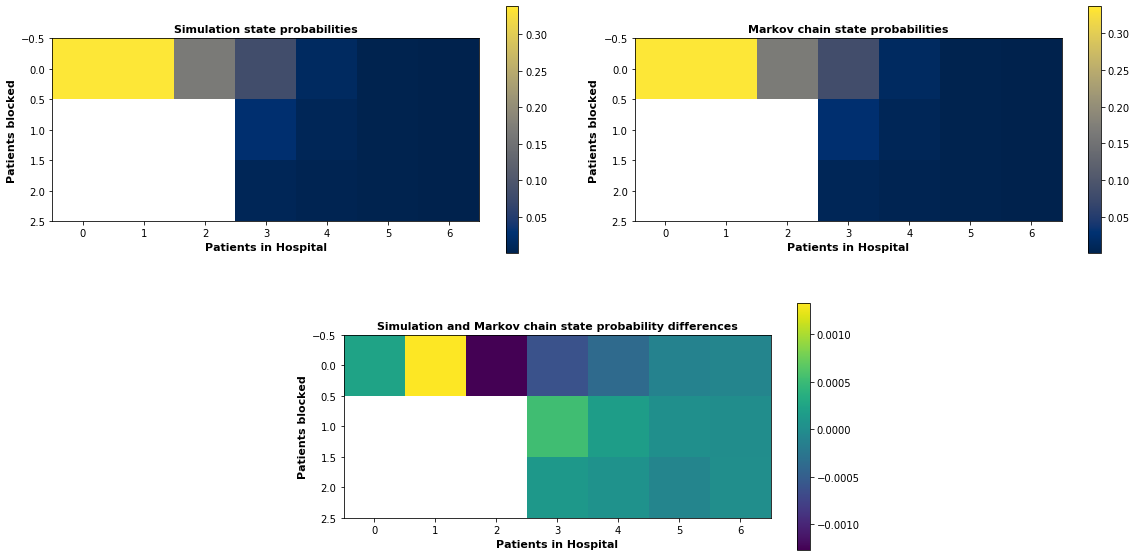

In [28]:
plt.figure(figsize=(20, 10))
abg.get_heatmaps(
    lambda_a=lambda_a,
    lambda_o=lambda_o,
    mu=mu,
    num_of_servers=num_of_servers,
    threshold=threshold,
    system_capacity=system_capacity,
    parking_capacity=parking_capacity,
    seed_num=seed_num,
    runtime=runtime,
    num_of_trials=num_of_trials,
)


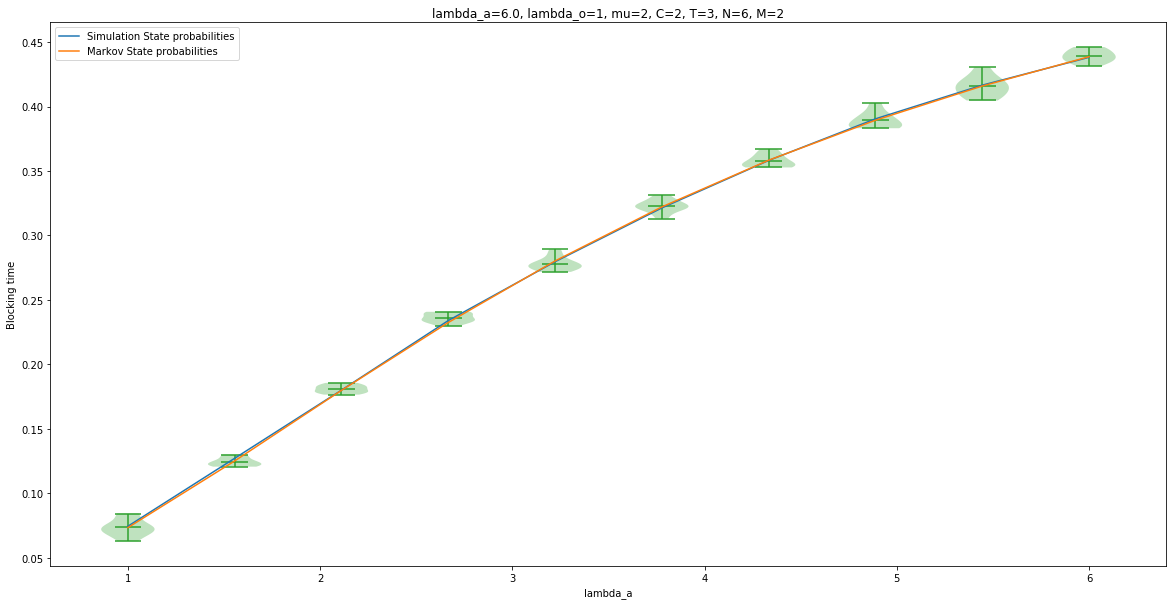

In [29]:
plot_over = "lambda_a"
max_parameter_value = 6
x_axis, mean_sim, mean_markov, all_sim = get_plot_comparing_times(
    lambda_a=lambda_a,
    lambda_o=lambda_o,
    mu=mu,
    num_of_servers=num_of_servers,
    threshold=threshold,
    num_of_trials=num_of_trials,
    seed_num=seed_num,
    runtime=runtime,
    system_capacity=system_capacity,
    parking_capacity=parking_capacity,
    plot_over=plot_over,
    max_parameter_value=max_parameter_value,
    accuracy=accuracy,
)


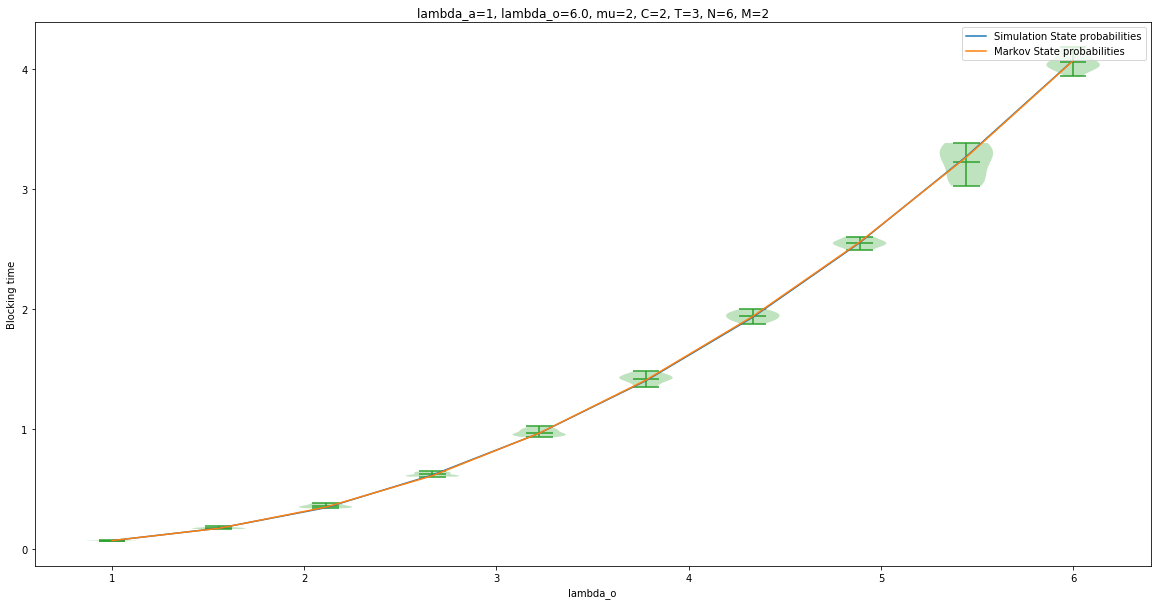

In [33]:
plot_over = "lambda_o"
max_parameter_value = 6
x_axis, mean_sim, mean_markov, all_sim = get_plot_comparing_times(
    lambda_a=lambda_a,
    lambda_o=lambda_o,
    mu=mu,
    num_of_servers=num_of_servers,
    threshold=threshold,
    num_of_trials=num_of_trials,
    seed_num=seed_num,
    runtime=runtime,
    system_capacity=system_capacity,
    parking_capacity=parking_capacity,
    plot_over=plot_over,
    max_parameter_value=max_parameter_value,
    accuracy=accuracy,
)

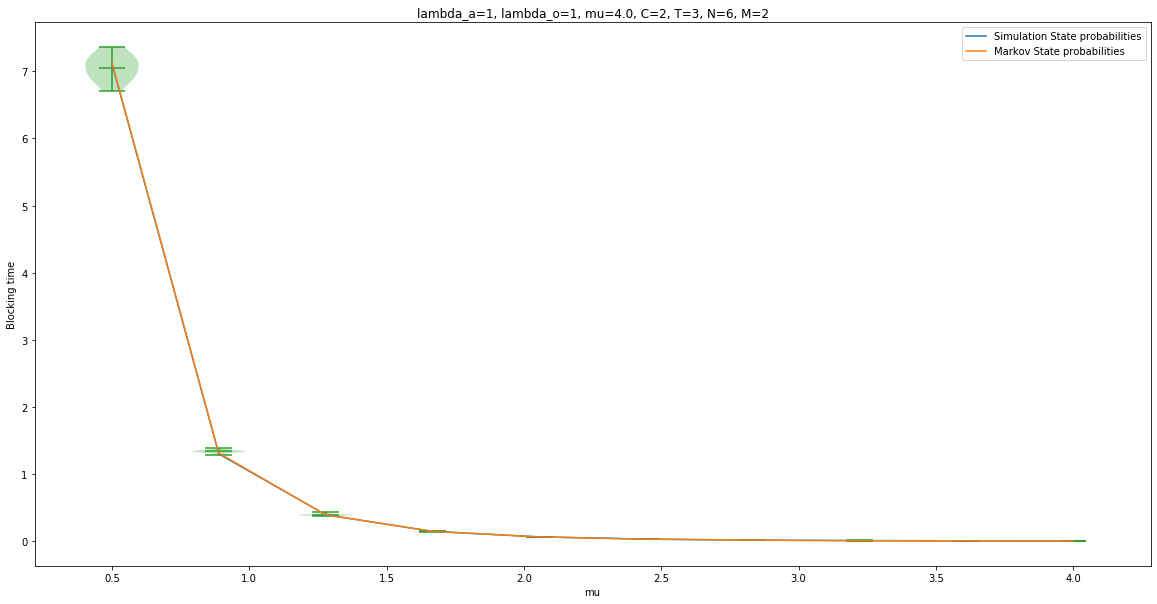

In [29]:
plot_over = "mu"
max_parameter_value = 4
x_axis, mean_sim, mean_markov, all_sim = get_plot_comparing_times(
    lambda_a=lambda_a,
    lambda_o=lambda_o,
    mu=0.5,
    num_of_servers=num_of_servers,
    threshold=threshold,
    num_of_trials=num_of_trials,
    seed_num=seed_num,
    runtime=runtime,
    system_capacity=system_capacity,
    parking_capacity=parking_capacity,
    plot_over=plot_over,
    max_parameter_value=max_parameter_value,
    accuracy=accuracy,
)

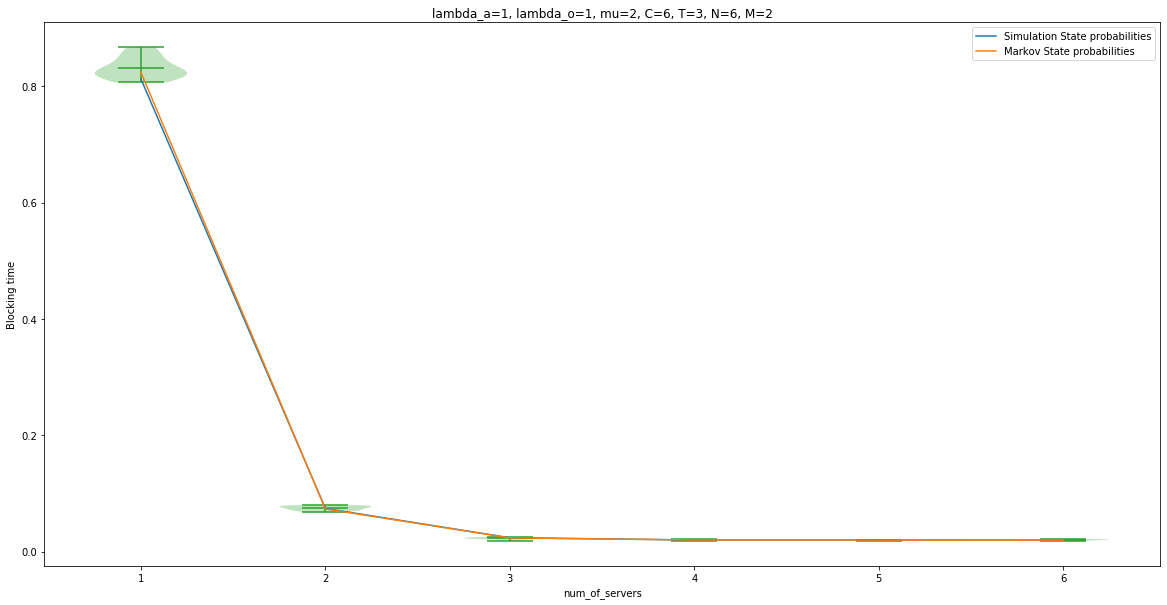

In [35]:
plot_over = "num_of_servers"
max_parameter_value = 6
x_axis, mean_sim, mean_markov, all_sim = get_plot_comparing_times(
    lambda_a=lambda_a,
    lambda_o=lambda_o,
    mu=mu,
    num_of_servers=1,
    threshold=threshold,
    num_of_trials=num_of_trials,
    seed_num=seed_num,
    runtime=runtime,
    system_capacity=system_capacity,
    parking_capacity=parking_capacity,
    plot_over=plot_over,
    max_parameter_value=max_parameter_value,
    accuracy=6,
)

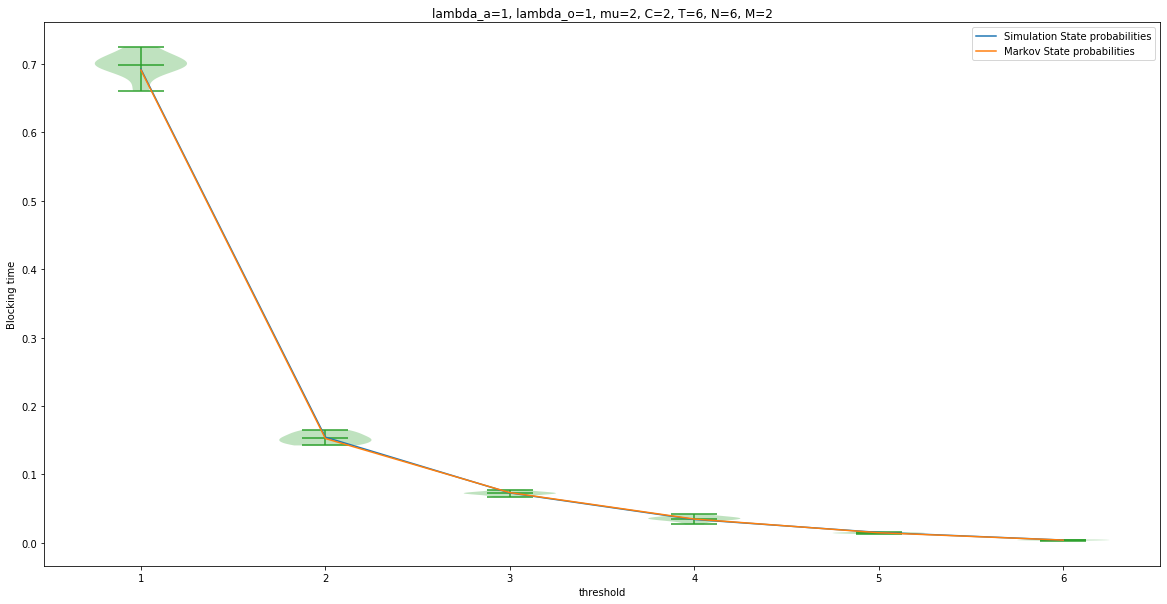

In [36]:
plot_over = "threshold"
max_parameter_value = 6
x_axis, mean_sim, mean_markov, all_sim = get_plot_comparing_times(
    lambda_a=lambda_a,
    lambda_o=lambda_o,
    mu=mu,
    num_of_servers=num_of_servers,
    threshold=1,
    num_of_trials=num_of_trials,
    seed_num=seed_num,
    runtime=runtime,
    system_capacity=system_capacity,
    parking_capacity=parking_capacity,
    plot_over=plot_over,
    max_parameter_value=max_parameter_value,
    accuracy=6,
)

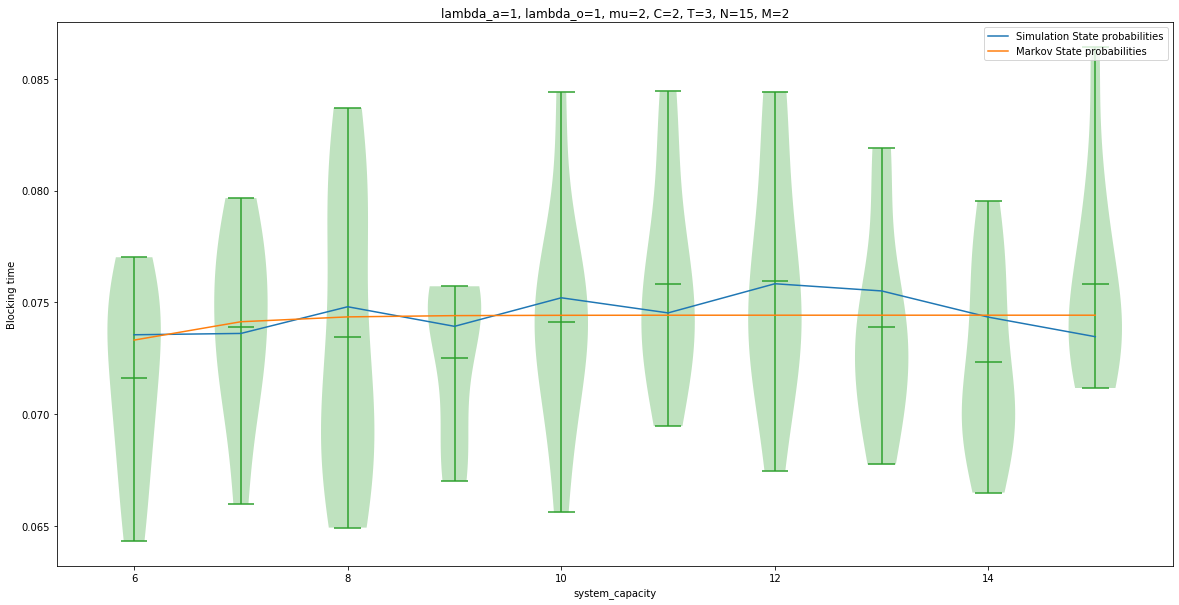

In [37]:
plot_over = "system_capacity"
max_parameter_value = 15
x_axis, mean_sim, mean_markov, all_sim = get_plot_comparing_times(
    lambda_a=lambda_a,
    lambda_o=lambda_o,
    mu=mu,
    num_of_servers=num_of_servers,
    threshold=threshold,
    num_of_trials=num_of_trials,
    seed_num=seed_num,
    runtime=runtime,
    system_capacity=system_capacity,
    parking_capacity=parking_capacity,
    plot_over=plot_over,
    max_parameter_value=max_parameter_value,
    accuracy=accuracy,
)

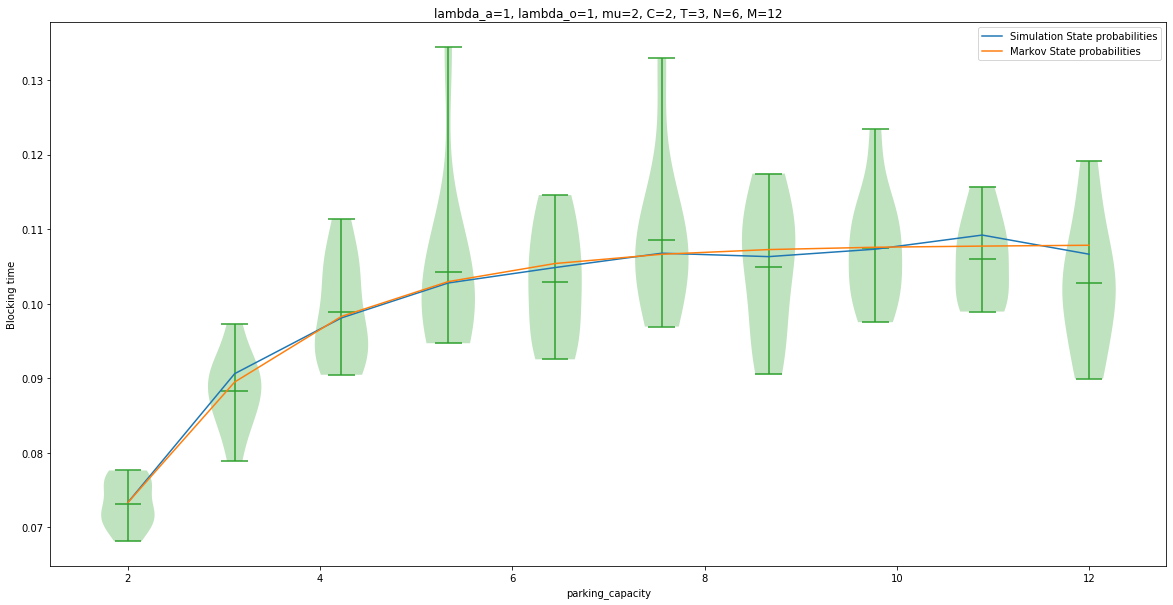

In [38]:
plot_over = "parking_capacity"
max_parameter_value = 12
x_axis, mean_sim, mean_markov, all_sim = get_plot_comparing_times(
    lambda_a=lambda_a,
    lambda_o=lambda_o,
    mu=mu,
    num_of_servers=num_of_servers,
    threshold=threshold,
    num_of_trials=num_of_trials,
    seed_num=seed_num,
    runtime=runtime,
    system_capacity=system_capacity,
    parking_capacity=parking_capacity,
    plot_over=plot_over,
    max_parameter_value=max_parameter_value,
    accuracy=accuracy,
)